# Evaluate model on graph

This script takes a GNN model and evaluates a graph on it, saving real and predicted datasets as .pt

In [1]:
#Get the current working directory
import os
cwd = os.getcwd()
MODEL_NTRACKS = '500'
NTRACKS = '50'
file_path = cwd + f'/points_{NTRACKS}.csv'
edge_path = cwd + f'/graph_{NTRACKS}.csv'
model_path = cwd + f'/model_{MODEL_NTRACKS}_all.pth'

save_ref = f'ref_data_{NTRACKS}_model{MODEL_NTRACKS}.pt'
save_pred = f'pred_data_{NTRACKS}_model{MODEL_NTRACKS}.pt'

In [2]:
#Libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch
from torch import Tensor
os.environ['TORCH'] = torch.__version__
print(torch.__version__)

2.3.1+cu121


In [3]:
df=pd.read_csv(file_path)

#Round the values of the dataset to 4 decimal places
df = df.round(4)

#Add a column to use as index from 0 to the length of the dataset
df['n_label'] = range(0, len(df))

#delete the column p_label
#df = df.drop('p_label', axis=1)

df

,x,y,z,N_side,N_layer,t_label,phi,eta,q,pt,d0,z0,n_label
0,9.2160,-4.0798,8.9277,11,1,T0,-0.4467,0.8019,1,69.2915,0.3108,-0.0455,0
1,17.6857,-8.1630,17.3026,11,2,T0,-0.4467,0.8019,1,69.2915,0.3108,-0.0455,1
2,26.7532,-12.5528,26.2758,11,3,T0,-0.4467,0.8019,1,69.2915,0.3108,-0.0455,2
3,35.2094,-16.6637,34.6508,11,4,T0,-0.4467,0.8019,1,69.2915,0.3108,-0.0455,3
4,44.2625,-21.0831,43.6240,11,5,T0,-0.4467,0.8019,1,69.2915,0.3108,-0.0455,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,9.9211,-57.2635,-283.9743,9,6,T49,-1.4088,-2.2889,-1,28.5718,-0.1314,-0.2593,495
496,11.7391,-66.8392,-331.5538,9,7,T49,-1.4088,-2.2889,-1,28.5718,-0.1314,-0.2593,496
497,13.5951,-76.4076,-379.1333,9,8,T49,-1.4088,-2.2889,-1,28.5718,-0.1314,-0.2593,497
498,15.4537,-85.7915,-425.8318,9,9,T49,-1.4088,-2.2889,-1,28.5718,-0.1314,-0.2593,498


In [4]:
import torch_geometric.transforms as T
from torch_geometric.data import HeteroData

In [5]:
#Empty hetero graph 
data=HeteroData()

#node names
nodes_s=df['n_label'].values
nodes_t=df['n_label'].values

#Add nodes to the graph
data['source'].node_id = torch.tensor(nodes_s, dtype=torch.long)
data['target'].node_id = torch.tensor(nodes_t, dtype=torch.long)

#Add node attributes, in this case the position of the points
data['source'].x = Tensor(df[['x', 'y', 'z']].values)
data['target'].x = Tensor(df[['x', 'y', 'z']].values)

In [6]:
# Importing the dataset
df_edge = pd.read_csv(edge_path)
df_edge = df_edge.replace({'weight':0.5}, 0.)

edge_index = torch.tensor([df_edge['Source'], df_edge['Target']], dtype=torch.long)
data['source', 'weight', 'target'].edge_index = edge_index

#edge attributes
weight_val = torch.from_numpy(df_edge['weight'].values).to(torch.float)
data['source', 'weight', 'target'].edge_label=weight_val

#check if the data is valid
data.validate(raise_on_error=True)

True

In [7]:
import torch_geometric.transforms as T
data = T.ToUndirected()(data)

del data['target', 'rev_weight', 'source'].edge_label
data.validate(raise_on_error=True)

True

In [8]:
torch.save(data,save_ref)
data

HeteroData(
  source={
    node_id=[500],
    x=[500, 3],
  },
  target={
    node_id=[500],
    x=[500, 3],
  },
  (source, weight, target)={
    edge_index=[2, 582],
    edge_label=[582],
  },
  (target, rev_weight, source)={ edge_index=[2, 582] }
)

## Load model

In [9]:
from torch_geometric.nn import SAGEConv, to_hetero

class GNNEncoder(torch.nn.Module):
    def __init__(self, hidden_channels, out_channels):
        super().__init__()
        self.conv1 = SAGEConv((-1, -1), hidden_channels)
        self.conv2 = SAGEConv((-1, -1), out_channels)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index).relu()
        x = self.conv2(x, edge_index)
        return x


class EdgeDecoder(torch.nn.Module):
    def __init__(self, hidden_channels):
        super().__init__()
        self.lin1 = torch.nn.Linear(2 * hidden_channels, hidden_channels)
        self.lin2 = torch.nn.Linear(hidden_channels, 1)

    def forward(self, z_dict, edge_label_index):
        row, col = edge_label_index
        z = torch.cat([z_dict['source'][row], z_dict['target'][col]], dim=-1)

        z = self.lin1(z).relu()
        z = self.lin2(z)
        return z.view(-1)


class Model(torch.nn.Module):
    def __init__(self, hidden_channels):
        super().__init__()
        self.encoder = GNNEncoder(hidden_channels, hidden_channels)
        self.encoder = to_hetero(self.encoder, data.metadata(), aggr='sum')
        self.decoder = EdgeDecoder(hidden_channels)

    def forward(self, x_dict, edge_index_dict, edge_label_index):
        z_dict = self.encoder(x_dict, edge_index_dict)
        return self.decoder(z_dict, edge_label_index)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = Model(hidden_channels=32).to(device)

In [10]:
model.load_state_dict(torch.load(model_path))
model

Model(
  (encoder): GraphModule(
    (conv1): ModuleDict(
      (source__weight__target): SAGEConv((-1, -1), 32, aggr=mean)
      (target__rev_weight__source): SAGEConv((-1, -1), 32, aggr=mean)
    )
    (conv2): ModuleDict(
      (source__weight__target): SAGEConv((-1, -1), 32, aggr=mean)
      (target__rev_weight__source): SAGEConv((-1, -1), 32, aggr=mean)
    )
  )
  (decoder): EdgeDecoder(
    (lin1): Linear(in_features=64, out_features=32, bias=True)
    (lin2): Linear(in_features=32, out_features=1, bias=True)
  )
)

## Eval data

In [11]:
THRESHOLD = 0.1

import torch.nn.functional as F
import math

with torch.no_grad():
    data = data.to(device)
    pred = model(data.x_dict, data.edge_index_dict,
                 data['source', 'target'].edge_index)
    pred = pred.clamp(min=0, max=1)
    target = data['source', 'target'].edge_label.float()
    rmse = F.mse_loss(pred, target).sqrt()
    print(f'Test RMSE: {rmse:.4f}')

sour = data['source', 'target'].edge_index[0].cpu().numpy()
tar = data['source', 'target'].edge_index[1].cpu().numpy()
pred = pred.cpu().numpy()
target = target.cpu().numpy()

pred_cleaned_0 = np.zeros(pred.size)
for id in range(sour.size):
    # First pass based on sources
    # get all possible edges with this source
    cands_sour = np.array(sour[sour==id])
    cands_pred = np.array(pred[sour==id])
    cands_ids = np.array(np.where(sour==id)[0])
    #print(cands_sour, cands_pred, cands_ids)
    max_score, max_id = -1.,-1
    # loop over cands to determine highest score
    for j in range(cands_sour.size):
        if cands_pred[j] > max(THRESHOLD,max_score):
            max_score = cands_pred[j]
            max_id = j
    # set to zero other preds
    if max_score > -1:
        for j in range(cands_sour.size):
            if j != max_id: pred_cleaned_0[cands_ids[j]] = 0.
            else: pred_cleaned_0[cands_ids[j]] = pred[cands_ids[j]]

pred_cleaned = np.zeros(pred.size)
for id in range(sour.size):
    # Second pass based on targets
    # get all possible edges with this target
    cands_t_tar = np.array(tar[tar==id])
    cands_t_pred = np.array(pred_cleaned_0[tar==id])
    cands_t_ids = np.array(np.where(tar==id)[0])
    max_score, max_id = -1.,-1
    # loop over cands to determine highest score
    for k in range(cands_t_tar.size):
        if cands_t_pred[k] > max(THRESHOLD,max_score):
            max_score = cands_t_pred[k]
            max_id = k
    # set to zero other preds
    if max_score > -1:
        for k in range(cands_t_tar.size):
            if k != max_id: pred_cleaned[cands_t_ids[k]] = 0.
            else: pred_cleaned[cands_t_ids[k]] = pred_cleaned_0[cands_t_ids[k]]
        

res=pd.DataFrame({'source': sour, 'target': tar, 'pred': pred, 'pred_cleaned': pred_cleaned, 'compare': target})
#Add a new column if pred is greater or equal than 0.5 then 1 else 0.5
res['weight'] = np.where(res['pred_cleaned']>=THRESHOLD, 1., 0.)
res

Test RMSE: 0.3408


,source,target,pred,pred_cleaned,compare,weight
0,0,1,0.204471,0.000000,1.0,0.0
1,0,91,0.088495,0.000000,0.0,0.0
2,0,111,0.319875,0.319875,0.0,1.0
3,10,11,0.260030,0.260030,1.0,1.0
4,20,21,0.150373,0.000000,1.0,0.0
...,...,...,...,...,...,...
577,458,459,1.000000,1.000000,1.0,1.0
578,468,469,1.000000,1.000000,1.0,1.0
579,478,479,1.000000,1.000000,1.0,1.0
580,488,489,0.974371,0.974371,1.0,1.0


In [12]:
res[res['source']==0]
res.size

3492

In [13]:
#compare column rating_1 with target and if they are equal add up
cont=0
for i in res.itertuples():
    if i.compare == i.weight:
        cont+=1

#Calculate the accuracy
accuracy = cont/len(res)
print('Accuracy:', accuracy)
print('Number of correct predictions:', cont)

connected_accuracy = 0.
nonconnected_accuracy = 0.

n1,n2=0,0
ncon,nncon=0,0
for i in res.itertuples():
    if i.compare == 0.:
        if i.compare == i.weight: n1+=1
        nncon+=1
    elif i.compare == 1.0:
        if i.compare == i.weight: n2+=1
        ncon+=1

connected_accuracy = n2/ncon
nonconnected_accuracy = n1/nncon

print(f'Accuracy in connected edges:     {n2}/{ncon} = {connected_accuracy}')
print(f'Accuracy in non connected edges: {n1}/{nncon} = {nonconnected_accuracy}')

Accuracy: 0.9467353951890034
Number of correct predictions: 551
Accuracy in connected edges:     428/450 = 0.9511111111111111
Accuracy in non connected edges: 123/132 = 0.9318181818181818


In [14]:
pred_data = data

pred_data['source','weight','target']['edge_label'] = torch.tensor(res['weight'], dtype=torch.long)
print(pred_data['source','weight','target']['edge_label'])
torch.save(pred_data, save_pred)

tensor([0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1,
        0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1,
        0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0,
        0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1,
        0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1,
        1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0,
        1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1,
        1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1,
        1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0,
        0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1,
        0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

## Plot and save 2D and 3D figures

In [15]:
def drawGraph(dataset, ax):

    x = dataset['source'].x
    ax.plot(x[:,0].numpy(), x[:,1].numpy(), 'g*')
    edge_index = dataset['source', 'weight', 'target'].edge_index
    edge_label = dataset['source', 'weight', 'target'].edge_label
    #edge_label_index = dataset['source', 'weight', 'target'].edge_label_index
    print(edge_index.shape)
    print(edge_label.shape)
    #print(edge_label_index.shape)

    for i, edge in enumerate(torch.t(edge_index)):
        edge1 = edge[0].numpy()
        edge2 = edge[1].numpy()
        if edge_label[i] > 0.75:
            x1, y1 = x[edge1,0], x[edge1,1]
            x2, y2 = x[edge2,0], x[edge2,1]
            xg = []
            xg.append(x1)
            xg.append(x2)
            yg = []
            yg.append(y1)
            yg.append(y2)
            ax.plot(xg, yg, 'r-')

In [16]:
def drawGraph3D(dataset, ax):
    
    x = dataset['source'].x
    #ax.plot(x[:,0].numpy(), x[:,1].numpy(), 'g*')
    ax.plot(x[:,0].numpy(), x[:,1].numpy(), x[:,2].numpy(), 'g*')

    edge_index = dataset['source', 'weight', 'target'].edge_index
    edge_label = dataset['source', 'weight', 'target'].edge_label

    for i, edge in enumerate(torch.t(edge_index)):
       
        edge1 = edge[0].numpy()
        edge2 = edge[1].numpy()
        if edge_label[i] > 0.5:
            #x1, y1 = x[edge1,0], x[edge1,1]
            #x2, y2 = x[edge2,0], x[edge2,1]
            x1, y1, z1 = x[edge1,0], x[edge1,1], x[edge1, 2]
            x2, y2, z2 = x[edge2,0], x[edge2,1], x[edge2, 2]
            xg = [] 
            xg.append(x1)
            xg.append(x2)
            yg = []
            yg.append(y1)
            yg.append(y2)
            zg = []
            zg.append(z1)
            zg.append(z2)
            #ax.plot(xg, yg, 'r-')    
            ax.plot(xg, yg, zg, 'r-')

torch.Size([2, 582])
torch.Size([582])
torch.Size([2, 582])
torch.Size([582])


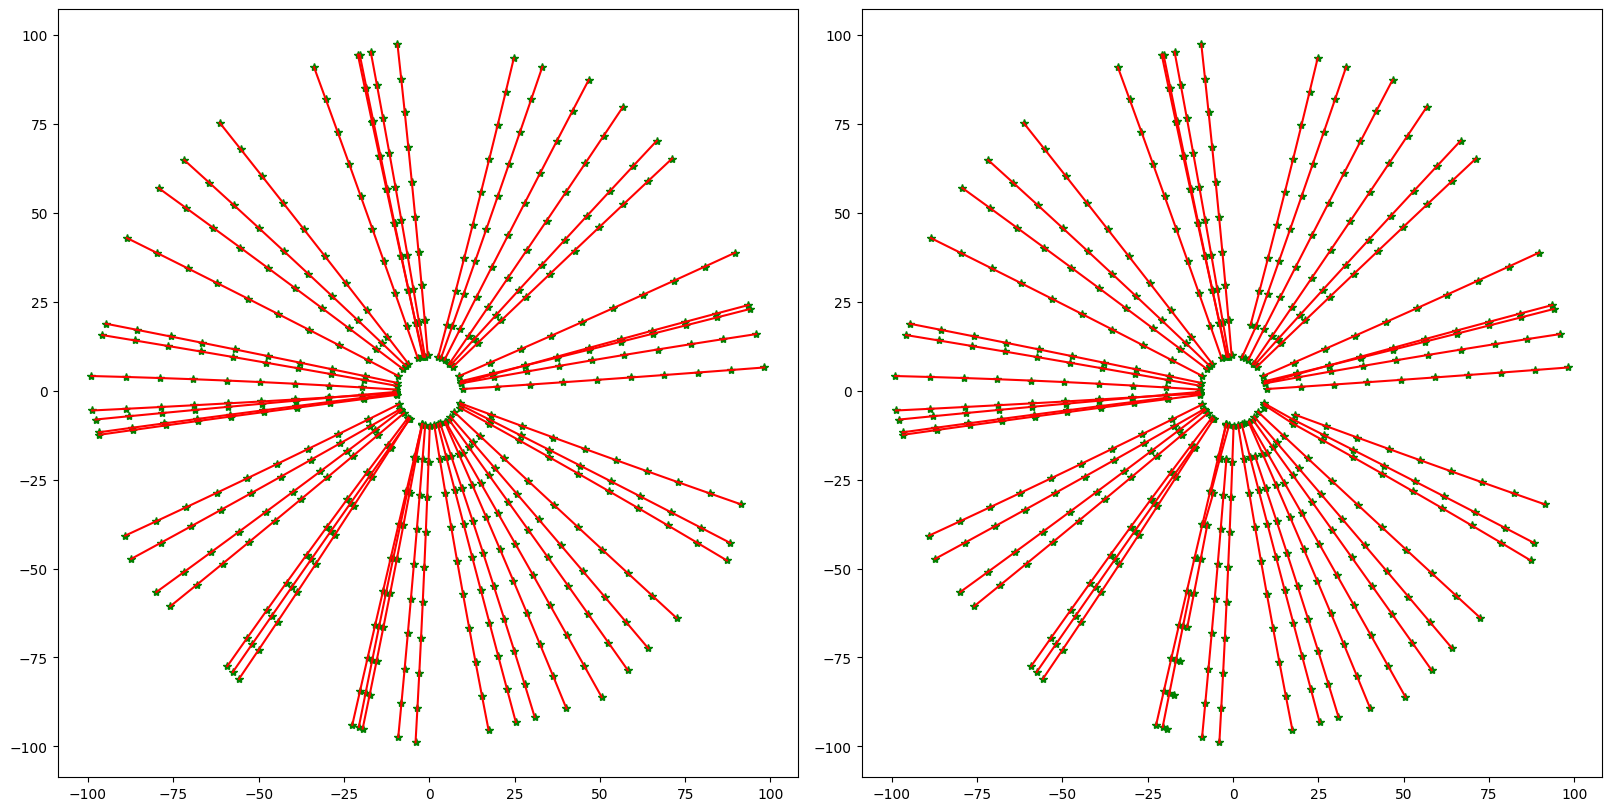

In [17]:
inputFile = f'ref_data_{NTRACKS}_model{MODEL_NTRACKS}.pt'
predFile = f'pred_data_{NTRACKS}_model{MODEL_NTRACKS}.pt'

dataset_real = torch.load(inputFile)
dataset_pred = torch.load(predFile)

fig = plt.figure(figsize = (16, 8), layout="constrained")
ax1 = fig.add_subplot(1,2,1)
ax2 = fig.add_subplot(1,2,2)
drawGraph(dataset_real, ax1)
drawGraph(dataset_pred, ax2)
plt.show()

fig.savefig(cwd + f'/figures/2Dtracks_{NTRACKS}.pdf', transparent=True, format='pdf')
fig.savefig(cwd + f'/figures/2Dtracks_{NTRACKS}.png', transparent=True, format='png')

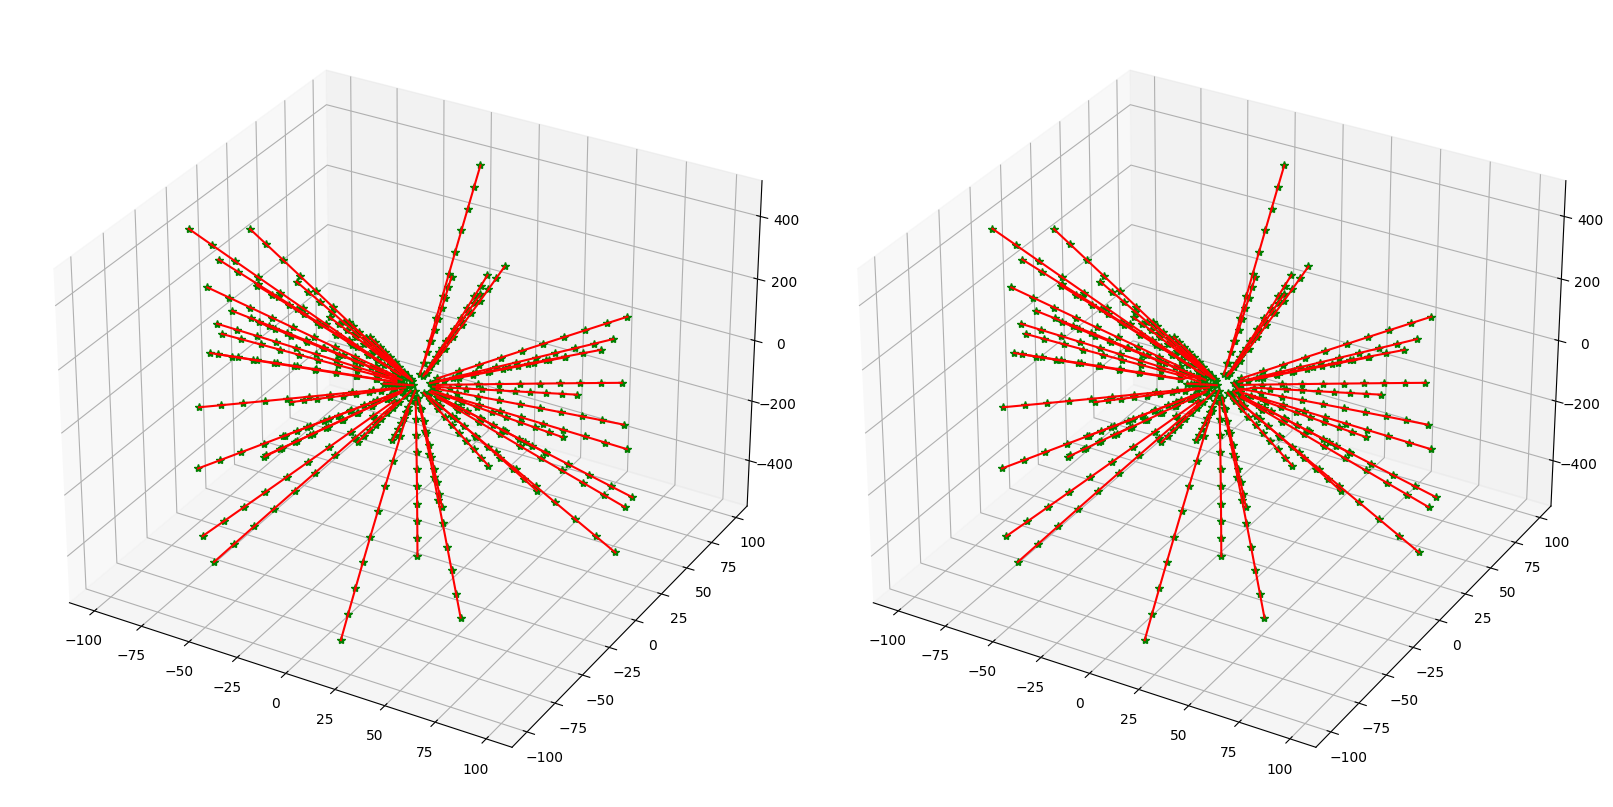

In [18]:
fig = plt.figure(figsize = (16, 8), layout="constrained")
ax1 = fig.add_subplot(1,2,1, projection = '3d')
ax2 = fig.add_subplot(1,2,2, projection = '3d')
drawGraph3D(dataset_real, ax1)
drawGraph3D(dataset_pred, ax2)
plt.show()

fig.savefig(cwd + f'/figures/3Dtracks_{NTRACKS}.pdf', transparent=True, format='pdf')
fig.savefig(cwd + f'/figures/3Dtracks_{NTRACKS}.png', transparent=True, format='png')

## Track metrics

In [19]:
def giveMeNext(edge_index, edge_label, target):
    for i in range(0, len(edge_index)):
        if edge_label[i] < 0.7:
            continue
        sou = int(edge_index[i,0].numpy())
        tar = int(edge_index[i,1].numpy())
        if sou == target:
            return True, tar
    return False, -1

In [20]:
def getPartners(index, label, source):
    sourcePartner = -1
    for i, edge in enumerate(index):
        sourceP = int(edge[0].numpy())
        targetP = int(edge[1].numpy())
        if sourceP == source and label[i] > 0.5:
            sourcePartner = targetP        
    return sourcePartner

In [21]:
def trackMetric(reference, prediction):
    #We identify tracks by the first node
    x = reference['source'].x
    edge_index = torch.t(reference['source', 'weight', 'target'].edge_index)
    edge_label = reference['source', 'weight', 'target'].edge_label

    lista = dict()
    #I fill the seeds for the tracks
    for i, ix in enumerate(x):
        r = math.sqrt(ix[0]**2 + ix[1]**2)
        if r < 11.0:
            lista[i] = []
            
    #I create the dictionary for the ground truth
    for i, edge in enumerate(edge_index):

        if edge_label[i] < 0.7:
            continue
        source = int(edge[0].numpy())
        target = int(edge[1].numpy())
        
        if source in lista:
            lista[source].append(source)        
            lista[source].append(target)
            continueSearching = True
            while continueSearching:
                valid, next = giveMeNext(edge_index, edge_label, target)
                if valid:
                    lista[source].append(next)
                    target = next
                else:
                    continueSearching = False
    
    #Now getting the information for the target dataset
    x_pred = prediction['source'].x
    edge_index_pred = torch.t(prediction['source', 'weight', 'target'].edge_index)
    edge_label_pred = prediction['source', 'weight', 'target'].edge_label
    
    #Creating track results
    tracks = dict()

    for source, tr in lista.items():
        goodLink = 0
        missingLink = 0
        fakeLink = 0
        tracks[source] = []
        for i, node in enumerate(tr):
            thesource = tr[i]
            if i < len(tr)-1:
                target = tr[i+1]
            else:
                target = -1
            sourcePartner = getPartners(edge_index_pred, edge_label_pred, thesource)
            if target == -1:
                if sourcePartner != -1:
                    fakeLink = fakeLink + 1
            else:
                if target == sourcePartner:
                    goodLink = goodLink + 1
                elif sourcePartner == -1:
                    missingLink = missingLink + 1
                else:
                    fakeLink = fakeLink + 1
        tracks[source].append(goodLink)
        tracks[source].append(fakeLink)
        tracks[source].append(missingLink)
            
    return tracks

In [22]:
tracks = trackMetric(dataset_real, dataset_pred)

In [23]:
goodTracks = 0
totalTracks = 0
for s, t in tracks.items():
    #print(s, t[0], t[1], t[2])
    score = (t[0]) / (t[0] + t[1] + t[2])
    if score > 0.75: goodTracks += 1
    totalTracks += 1
print(f'Reconstructed tracks: {goodTracks}/{totalTracks} = {goodTracks/totalTracks}')

Reconstructed tracks: 48/50 = 0.96
